In [86]:
import pandas as pd
import numpy as np
import datetime as datetime
import os
from torch.utils.data import Dataset, DataLoader
import torch
import matplotlib.pyplot as plt
import re 

In [110]:
data_path = './sanitized_data/'
annotation_train_path = '../ml/dataset/annotation_train.csv'
dataset_train_path = '../ml/dataset/data_train.npy'
dataset_test_path = '../ml/dataset/data_test.npy'
annotation_test_path = '../ml/dataset/annotation_test.csv'


labels = ["abnormal_arm_swing", "abnormal_stride", "abnormal_upper_body", "good_running_posture"]
annotation_train = pd.DataFrame(columns=['label'])
annotation_test = pd.DataFrame(columns=['label'])
dataset_train_list = []
dataset_test_list = []

printed = 0

def process_file(file, label):
    df = pd.read_csv(os.path.join(data_path, label, file))
    ts = re.findall(r'\d+', file)[0]
    gender = df['gender'][0]
    height = int(df['height'][0])

    # Drop unnecessary columns
    df.drop(columns=['timestamp', 'second', 'group', 'gender', 'height'], inplace=True)
    # print first 90 rows
    # min-max normalization per group ([0~3), [3,6] columns)
    df.iloc[:, 0:3] = (df.iloc[:, 0:3]) / (df.iloc[:, 0:3].max())
    df.iloc[:, 3:6] = (df.iloc[:, 3:6]) / (df.iloc[:, 3:6].max() )
    df.drop(index=0, inplace=True)


    # Split dataset into 90 rows
    for i in range(len(df) - 90):
        yield df.iloc[i:i+90].values, label, i/(len(df) - 90)


In [111]:
for label_idx, label in enumerate(labels):
    print(label)
    files = [f for f in os.listdir(os.path.join(data_path, label)) if f != '.DS_Store']
    for file in files:
        print(file)
        
        for data, lbl, progress in process_file(file, label):
            if progress < 0.6:
                dataset_train_list.append(data)
                annotation_train.loc[len(annotation_train)] = label_idx
            else:
                dataset_test_list.append(data)
                annotation_test.loc[len(annotation_test)] = label_idx

# Convert list to numpy array
dataset_train_arr = np.array(dataset_train_list)
dataset_test_arr = np.array(dataset_test_list)
annotation_train.to_csv(annotation_train_path, index=False, header=False)
annotation_test.to_csv(annotation_test_path, index=False, header=False)
np.save(dataset_train_path, dataset_train_arr)
np.save(dataset_test_path, dataset_test_arr)


abnormal_arm_swing
1699943632083_result.csv
1699943699779_result.csv
1699943813895_result.csv
1699943939308_result.csv
1700133673276_result_1.csv
1700133673276_result_2.csv
1700134584694_result.csv
1700134671764_result_1.csv
1700134671764_result_2.csv
1700198380046_result_1.csv
1700198380046_result_2.csv
1700299976008_result.csv
1700300268849_result.csv
1700459313497_result_1.csv
1700459313497_result_2.csv
1700459396514_result.csv
1700738181518_result_1.csv
1700738181518_result_2.csv
1700738419454_result.csv
1700738613841_result.csv
1700738815835_result.csv
abnormal_stride
1699942358210_result_1.csv
1699942358210_result_2.csv
1699942469901_result.csv
1699942573013_result.csv
1699942717908_result.csv
1700133808156_result.csv
1700134779303_result_1.csv
1700134779303_result_2.csv
1700134899117_result.csv
1700198591430_result.csv
1700199070128_result_1.csv
1700199070128_result_2.csv
1700738957793_result.csv
1700739058447_result.csv
1700739440671_result_1.csv
1700739440671_result_2.csv
1700

In [112]:
# show shape of ml/dataset/data.npy
print(dataset_test_arr.shape)
print(dataset_train_arr.shape)

(37530, 90, 6)
(56379, 90, 6)


In [117]:
class RunningDataset(Dataset):
    def __init__(self,annotation_path, dataset_path, transform=None):
        self.transform = transform
        self.labels = pd.read_csv(annotation_path, header=None)
        self.data = np.load(dataset_path)

        print (self.data.shape)
        print (self.labels.shape)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels.iloc[idx,0]
        label = torch.tensor(label, dtype=torch.int)

        if self.transform:
            sample = self.transform(sample)
        
        return sample, label


(56379, 90, 6)
(56379, 1)
(37530, 90, 6)
(37530, 1)
[inputs] dtype: torch.float64, shape: torch.Size([100, 90, 6])
[targets] dtype: torch.int32, shape: torch.Size([100])
[inputs] dtype: torch.float64, shape: torch.Size([100, 90, 6])
[targets] dtype: torch.int32, shape: torch.Size([100])
Feature batch shape: torch.Size([100, 90, 6])
Labels batch shape: torch.Size([100])


ValueError: axes don't match array

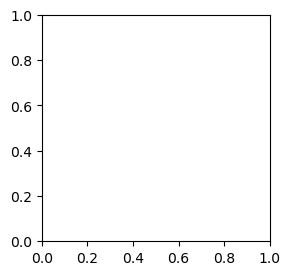

In [121]:
train_dataset = RunningDataset(annotation_train_path, dataset_train_path)
test_dataset = RunningDataset(annotation_test_path, dataset_test_path)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=100,
    num_workers=0,
    pin_memory=True,
    shuffle=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=100,
    num_workers=0,
    pin_memory=True,
    shuffle=True,
)

for inputs, targets in train_dataloader:
    print("[inputs] dtype: {}, shape: {}".format(inputs.dtype, inputs.shape))
    print("[targets] dtype: {}, shape: {}".format(targets.dtype, targets.shape))
    break

for inputs, targets in test_dataloader:
    print("[inputs] dtype: {}, shape: {}".format(inputs.dtype, inputs.shape))
    print("[targets] dtype: {}, shape: {}".format(targets.dtype, targets.shape))
    break

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")